In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data
outcomes = pd.read_csv('outcomes.csv')
baseline_results = pd.read_csv('Baseline_results_final_seed_1.csv', index_col=0)
fusion_results = pd.read_csv('Fusion_results_final_seed_1.csv', index_col=0)

# Display basic info
print("Outcomes data shape:", outcomes.shape)
print("Baseline results shape:", baseline_results.shape)
print("Fusion results shape:", fusion_results.shape)
print("\nOutcomes columns:", outcomes.columns.tolist())
print("\nFirst few rows of outcomes:")
print(outcomes.head())

Outcomes data shape: (21, 8)
Baseline results shape: (21, 11)
Fusion results shape: (21, 11)

Outcomes columns: ['subj', 'type', 'outcome', 'targets', 'soz', 'n_stim', 'n_resp', 'percent_soz']

First few rows of outcomes:
     subj     type        outcome  targets  soz  n_stim  n_resp  percent_soz
0  Epat26      rns  non-responder       53   10      66     103     0.188679
1  Epat30     none            NaN       46    3      62      90     0.065217
2  Epat31  surgery            I-d       29    7      40      58     0.241379
3  Epat34     none            NaN       56    4      67     108     0.071429
4  Epat35  surgery            I-a       34    2      39      77     0.058824


In [5]:
# Merge the datasets
# Add model type identifier and merge
baseline_results['model'] = 'Baseline'
fusion_results['model'] = 'Fusion'

# Reset index to get patient IDs as a column
baseline_df = baseline_results.reset_index().rename(columns={'index': 'subj'})
fusion_df = fusion_results.reset_index().rename(columns={'index': 'subj'})

# Combine both model results
all_results = pd.concat([baseline_df, fusion_df], ignore_index=True)

# Merge with outcomes
merged_data = all_results.merge(outcomes, on='subj', how='inner')

print(f"Merged data shape: {merged_data.shape}")
print(f"\nPatients in merged dataset: {merged_data['subj'].nunique()}")
print(f"\nTreatment type distribution:")
print(merged_data[merged_data['model'] == 'Baseline']['type'].value_counts())
print(f"\nOutcome distribution (for applicable patients):")
print(merged_data[merged_data['model'] == 'Baseline']['outcome'].value_counts())

Merged data shape: (42, 20)

Patients in merged dataset: 21

Treatment type distribution:
type
surgery    7
rns        6
none       5
unknown    3
Name: count, dtype: int64

Outcome distribution (for applicable patients):
outcome
responder        4
unknown          3
I-a              2
non-responder    2
I-b              1
I-d              1
II-a             1
II-b             1
IV-b             1
Name: count, dtype: int64


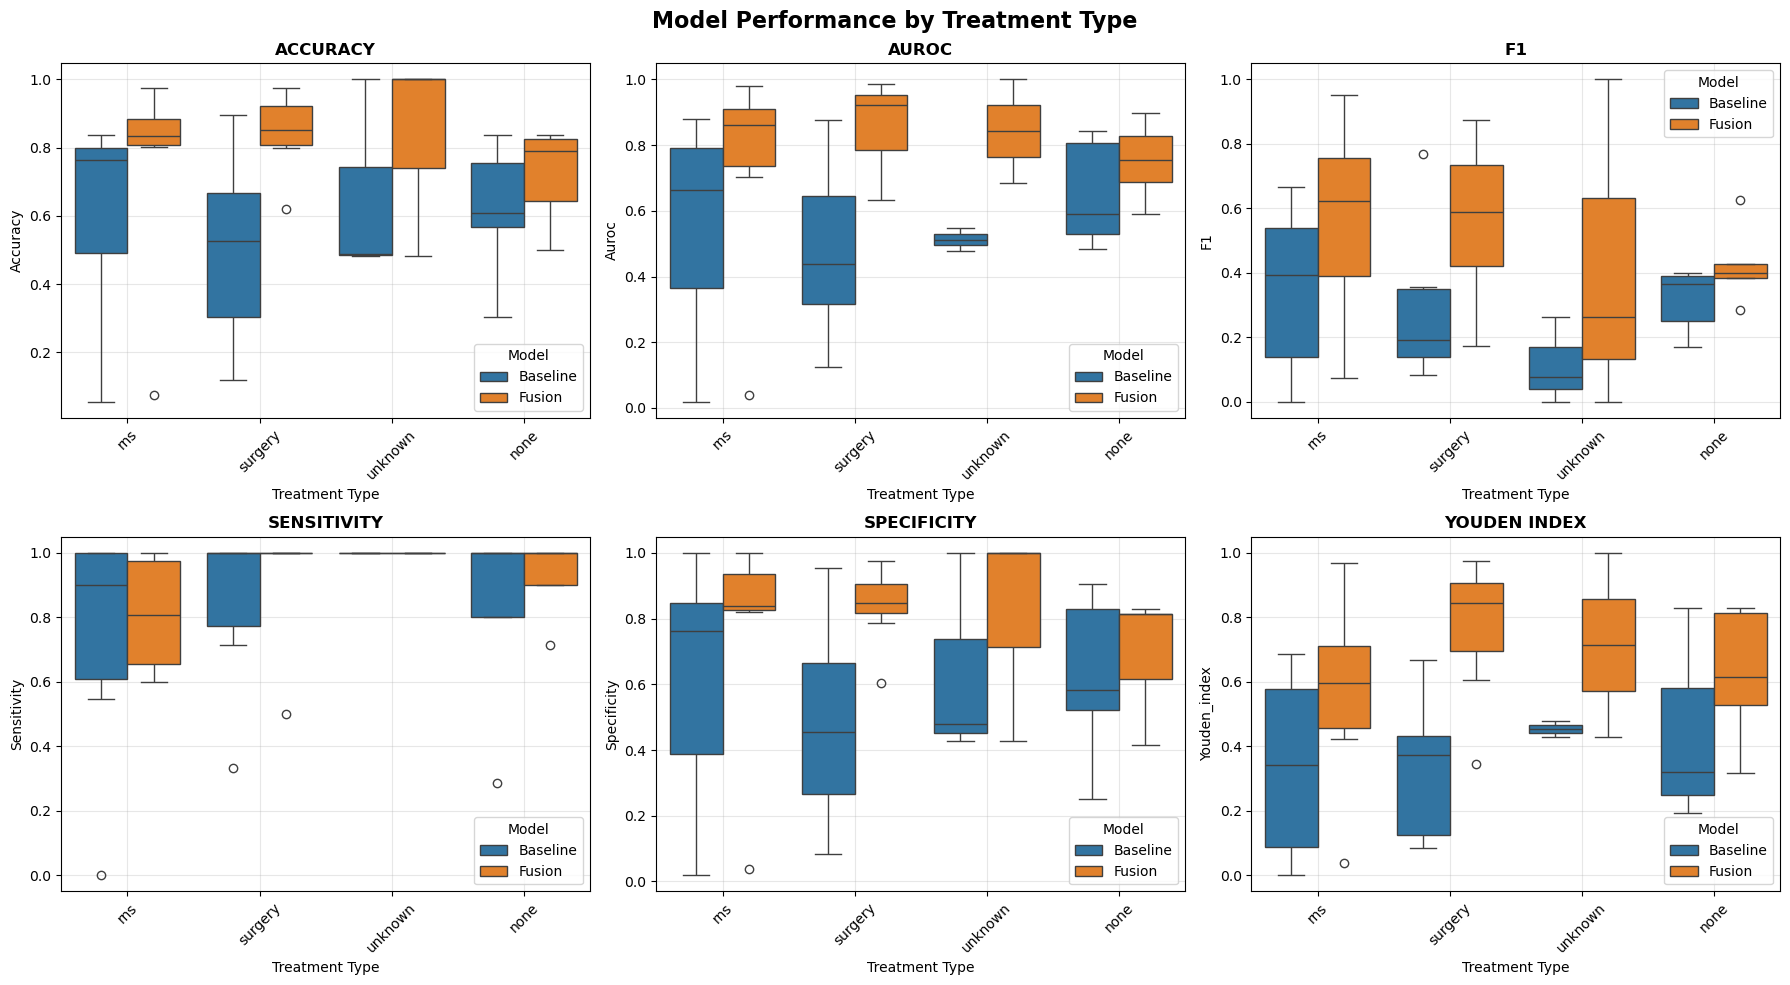


STATISTICAL SUMMARY: Performance by Treatment Type

Treatment: RNS

ACCURACY:
  Baseline - Mean: 0.6047, Std: 0.3129
  Fusion   - Mean: 0.7366, Std: 0.3304
  Improvement: 0.1319
  Paired t-test: t=-1.9318, p=0.1112

AUROC:
  Baseline - Mean: 0.5546, Std: 0.3361
  Fusion   - Mean: 0.7276, Std: 0.3503
  Improvement: 0.1730
  Paired t-test: t=-1.6481, p=0.1602

F1:
  Baseline - Mean: 0.3495, Std: 0.2675
  Fusion   - Mean: 0.5642, Std: 0.3182
  Improvement: 0.2148
  Paired t-test: t=-1.8962, p=0.1164

Treatment: SURGERY

ACCURACY:
  Baseline - Mean: 0.4974, Std: 0.2850
  Fusion   - Mean: 0.8441, Std: 0.1175
  Improvement: 0.3467
  Paired t-test: t=-3.5829, p=0.0116

AUROC:
  Baseline - Mean: 0.4808, Std: 0.2623
  Fusion   - Mean: 0.8606, Std: 0.1400
  Improvement: 0.3798
  Paired t-test: t=-3.6204, p=0.0111

F1:
  Baseline - Mean: 0.2888, Std: 0.2375
  Fusion   - Mean: 0.5640, Std: 0.2439
  Improvement: 0.2753
  Paired t-test: t=-3.0966, p=0.0212

Treatment: UNKNOWN

ACCURACY:
  Baseline 

In [6]:
# Analysis 1: Compare model performance by treatment type
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance by Treatment Type', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'auroc', 'f1', 'sensitivity', 'specificity', 'youden_index']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    
    # Create comparison plot
    data_to_plot = merged_data[merged_data[metric].notna()]
    
    sns.boxplot(data=data_to_plot, x='type', y=metric, hue='model', ax=ax)
    ax.set_title(f'{metric.upper().replace("_", " ")}', fontweight='bold')
    ax.set_xlabel('Treatment Type')
    ax.set_ylabel(metric.capitalize())
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Model', loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary by treatment type
print("\n" + "="*80)
print("STATISTICAL SUMMARY: Performance by Treatment Type")
print("="*80)

for treatment in merged_data['type'].unique():
    print(f"\n{'='*60}")
    print(f"Treatment: {treatment.upper()}")
    print(f"{'='*60}")
    
    treatment_data = merged_data[merged_data['type'] == treatment]
    
    for metric in ['accuracy', 'auroc', 'f1']:
        baseline_vals = treatment_data[treatment_data['model'] == 'Baseline'][metric].dropna()
        fusion_vals = treatment_data[treatment_data['model'] == 'Fusion'][metric].dropna()
        
        if len(baseline_vals) > 0 and len(fusion_vals) > 0:
            # Paired t-test (since same patients)
            t_stat, p_val = stats.ttest_rel(baseline_vals, fusion_vals)
            
            print(f"\n{metric.upper()}:")
            print(f"  Baseline - Mean: {baseline_vals.mean():.4f}, Std: {baseline_vals.std():.4f}")
            print(f"  Fusion   - Mean: {fusion_vals.mean():.4f}, Std: {fusion_vals.std():.4f}")
            print(f"  Improvement: {(fusion_vals.mean() - baseline_vals.mean()):.4f}")
            print(f"  Paired t-test: t={t_stat:.4f}, p={p_val:.4f}")

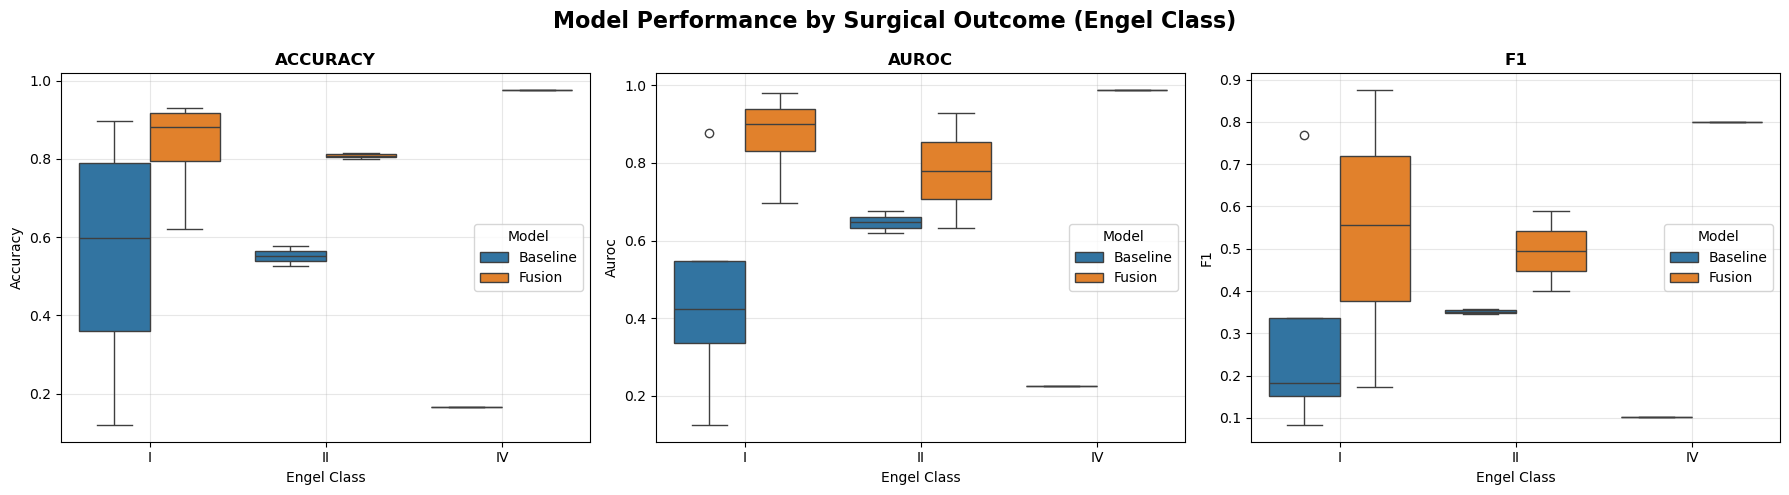


SURGICAL OUTCOMES ANALYSIS (Engel Classification)

Engel Class I (Better outcome = Class I)
Number of patients: 4

ACCURACY:
  Baseline: 0.5528 ± 0.3456
  Fusion:   0.8293 ± 0.1434
  Δ: +0.2764

AUROC:
  Baseline: 0.4618 ± 0.3104
  Fusion:   0.8692 ± 0.1220
  Δ: +0.4074

F1:
  Baseline: 0.3042 ± 0.3136
  Fusion:   0.5400 ± 0.3008
  Δ: +0.2358

Engel Class II (Better outcome = Class I)
Number of patients: 2

ACCURACY:
  Baseline: 0.5520 ± 0.0364
  Fusion:   0.8079 ± 0.0112
  Δ: +0.2558

AUROC:
  Baseline: 0.6467 ± 0.0403
  Fusion:   0.7799 ± 0.2085
  Δ: +0.1332

F1:
  Baseline: 0.3510 ± 0.0087
  Fusion:   0.4941 ± 0.1331
  Δ: +0.1431

Engel Class IV (Better outcome = Class I)
Number of patients: 1

ACCURACY:
  Baseline: 0.1667 ± nan
  Fusion:   0.9762 ± nan
  Δ: +0.8095

AUROC:
  Baseline: 0.2250 ± nan
  Fusion:   0.9875 ± nan
  Δ: +0.7625

F1:
  Baseline: 0.1026 ± nan
  Fusion:   0.8000 ± nan
  Δ: +0.6974


In [7]:
# Analysis 2: Surgical Outcomes (Engel Classification)
surgery_data = merged_data[merged_data['type'] == 'surgery'].copy()

if len(surgery_data) > 0:
    # Extract Engel class (I, II, III, IV)
    surgery_data['engel_class'] = surgery_data['outcome'].str.extract(r'([I|V]+)', expand=False)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Model Performance by Surgical Outcome (Engel Class)', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(['accuracy', 'auroc', 'f1']):
        ax = axes[idx]
        plot_data = surgery_data[surgery_data[metric].notna()]
        
        sns.boxplot(data=plot_data, x='engel_class', y=metric, hue='model', ax=ax)
        ax.set_title(f'{metric.upper()}', fontweight='bold')
        ax.set_xlabel('Engel Class')
        ax.set_ylabel(metric.capitalize())
        ax.legend(title='Model')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics by Engel class
    print("\n" + "="*80)
    print("SURGICAL OUTCOMES ANALYSIS (Engel Classification)")
    print("="*80)
    
    for engel in sorted(surgery_data['engel_class'].dropna().unique()):
        print(f"\n{'='*60}")
        print(f"Engel Class {engel} (Better outcome = Class I)")
        print(f"{'='*60}")
        
        engel_data = surgery_data[surgery_data['engel_class'] == engel]
        n_patients = engel_data['subj'].nunique()
        print(f"Number of patients: {n_patients}")
        
        for metric in ['accuracy', 'auroc', 'f1']:
            baseline_vals = engel_data[engel_data['model'] == 'Baseline'][metric].dropna()
            fusion_vals = engel_data[engel_data['model'] == 'Fusion'][metric].dropna()
            
            if len(baseline_vals) > 0 and len(fusion_vals) > 0:
                print(f"\n{metric.upper()}:")
                print(f"  Baseline: {baseline_vals.mean():.4f} ± {baseline_vals.std():.4f}")
                print(f"  Fusion:   {fusion_vals.mean():.4f} ± {fusion_vals.std():.4f}")
                print(f"  Δ: {(fusion_vals.mean() - baseline_vals.mean()):+.4f}")
else:
    print("No surgery patients found in dataset")

/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_99875/1520608653.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='engel_class', y=metric, ax=ax,
/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_99875/1520608653.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='engel_class', y=metric, ax=ax,
/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_99875/1520608653.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='engel_class', y=metric, ax=ax,
/

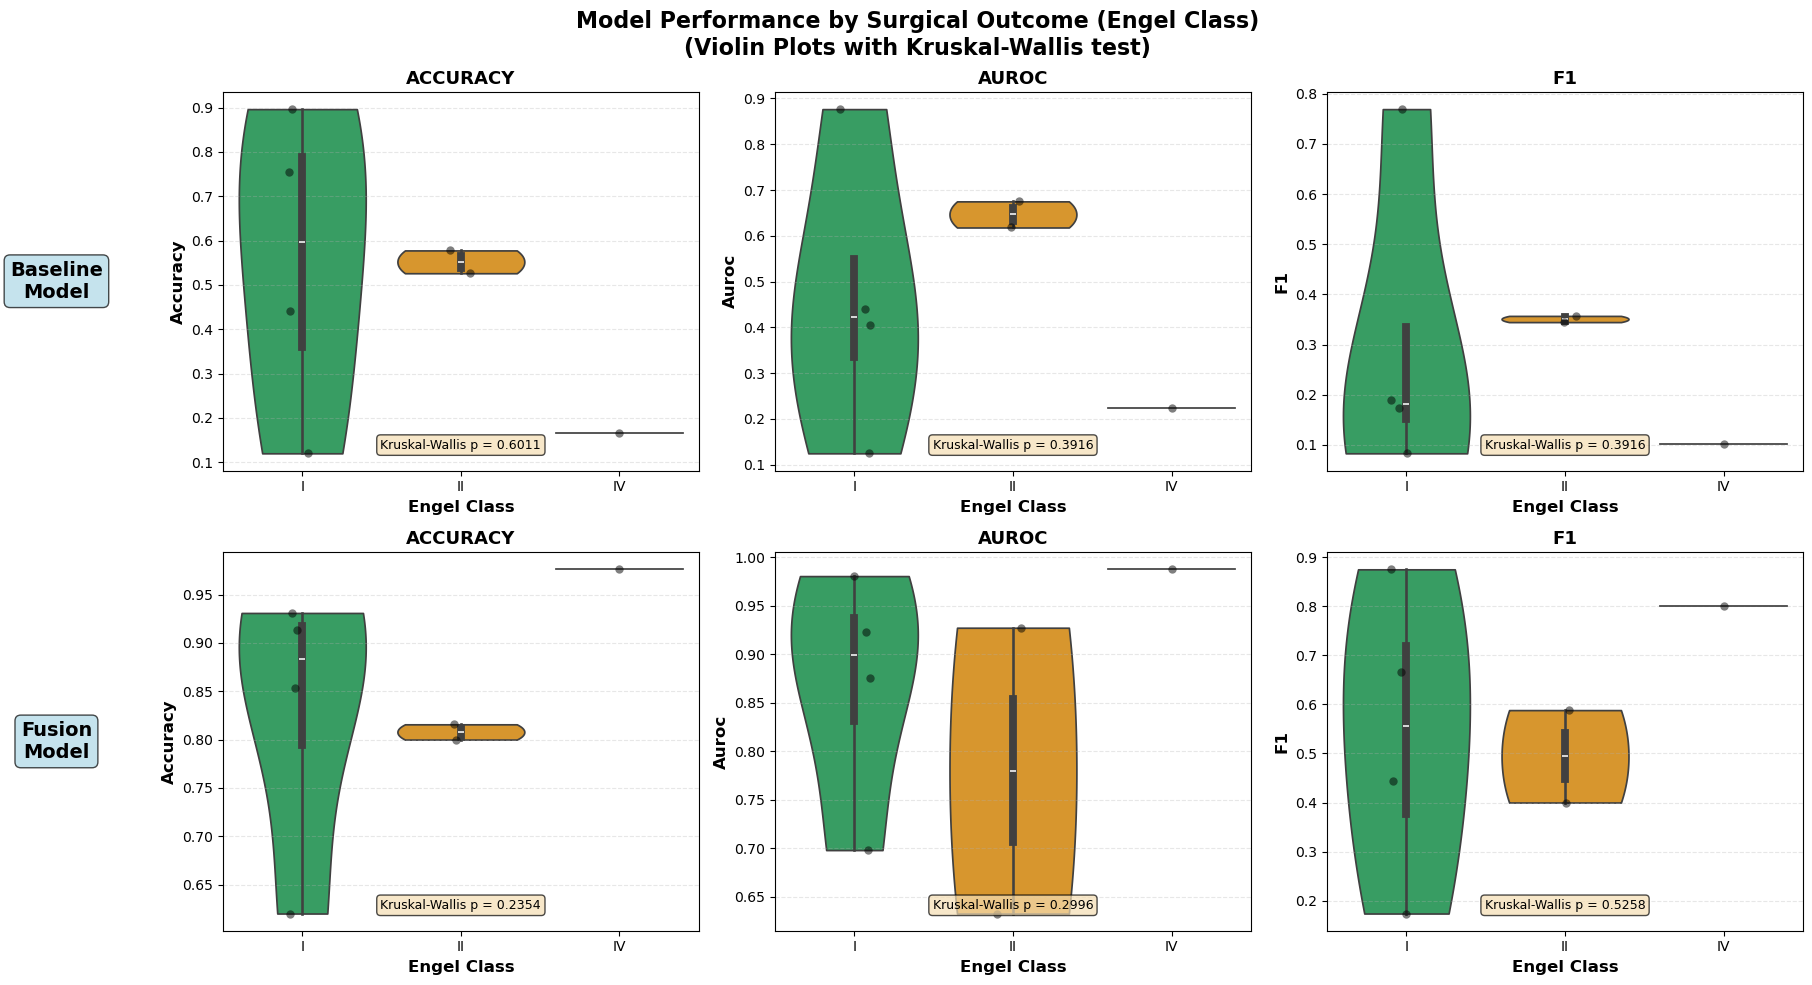


SURGICAL OUTCOMES ANALYSIS (Engel Classification) - REVISED

BASELINE MODEL

Engel Class I: n=4 (Lower = Better outcome)
  accuracy: 0.5528 ± 0.3456
  auroc: 0.4618 ± 0.3104
  f1: 0.3042 ± 0.3136

Engel Class II: n=2 (Lower = Better outcome)
  accuracy: 0.5520 ± 0.0364
  auroc: 0.6467 ± 0.0403
  f1: 0.3510 ± 0.0087

Engel Class IV: n=1 (Lower = Better outcome)
  accuracy: 0.1667 ± nan
  auroc: 0.2250 ± nan
  f1: 0.1026 ± nan

FUSION MODEL

Engel Class I: n=4 (Lower = Better outcome)
  accuracy: 0.8293 ± 0.1434
  auroc: 0.8692 ± 0.1220
  f1: 0.5400 ± 0.3008

Engel Class II: n=2 (Lower = Better outcome)
  accuracy: 0.8079 ± 0.0112
  auroc: 0.7799 ± 0.2085
  f1: 0.4941 ± 0.1331

Engel Class IV: n=1 (Lower = Better outcome)
  accuracy: 0.9762 ± nan
  auroc: 0.9875 ± nan
  f1: 0.8000 ± nan

SIGNIFICANCE LEVELS: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05
Note: Kruskal-Wallis test used for overall comparison (non-parametric)
      Mann-Whitney U test used for pairwise comparisons when signi

In [11]:
# Analysis 2 REVISED: Surgical Outcomes with Violin Plots
surgery_data_revised = merged_data[merged_data['type'] == 'surgery'].copy()

def add_engel_stat_annotation(ax, x1, x2, y, p_value, h=0.02):
    """Add statistical significance annotation to plot"""
    if p_value < 0.001:
        sig_symbol = '***'
    elif p_value < 0.01:
        sig_symbol = '**'
    elif p_value < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'
    
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*0.5, y+h, sig_symbol, ha='center', va='bottom', fontsize=10, fontweight='bold')

if len(surgery_data_revised) > 0:
    # Extract Engel class (I, II, III, IV)
    surgery_data_revised['engel_class'] = surgery_data_revised['outcome'].str.extract(r'([I|V]+)', expand=False)
    
    # Create separate plots for Baseline and Fusion models
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Performance by Surgical Outcome (Engel Class)\n(Violin Plots with Kruskal-Wallis test)',
                 fontsize=16, fontweight='bold')
    
    key_metrics = ['accuracy', 'auroc', 'f1']
    
    # Color palette for Engel classes (darker = better outcome)
    engel_palette = {
        'I': '#27ae60',    # Dark green - best outcome
        'II': '#f39c12',   # Orange - moderate outcome  
        'III': '#e67e22',  # Dark orange
        'IV': '#c0392b'    # Red - worst outcome
    }
    
    for model_idx, model_type in enumerate(['Baseline', 'Fusion']):
        model_data = surgery_data_revised[surgery_data_revised['model'] == model_type]
        
        for metric_idx, metric in enumerate(key_metrics):
            ax = axes[model_idx, metric_idx]
            
            # Create violin plot using seaborn
            plot_data = model_data[model_data[metric].notna()]
            
            # Get available Engel classes for this data
            available_classes = sorted(plot_data['engel_class'].dropna().unique())
            
            if len(available_classes) > 0:
                # Create palette for available classes
                current_palette = {k: engel_palette.get(k, '#95a5a6') for k in available_classes}
                
                sns.violinplot(data=plot_data, x='engel_class', y=metric, ax=ax,
                              palette=current_palette, inner='box', cut=0,
                              order=available_classes)
                
                # Add individual points
                sns.stripplot(data=plot_data, x='engel_class', y=metric, ax=ax,
                             color='black', alpha=0.5, size=6, jitter=True,
                             order=available_classes)
                
                # Statistical test: Kruskal-Wallis (non-parametric ANOVA for small samples)
                if len(available_classes) > 1:
                    from scipy.stats import kruskal
                    groups = [plot_data[plot_data['engel_class'] == ec][metric].dropna() 
                             for ec in available_classes]
                    groups = [g for g in groups if len(g) > 0]
                    
                    if len(groups) > 1:
                        h_stat, p_val = kruskal(*groups)
                        
                        # Add p-value text
                        ax.text(0.5, 0.05, f'Kruskal-Wallis p = {p_val:.4f}', 
                               transform=ax.transAxes,
                               ha='center', va='bottom', fontsize=9,
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
                        
                        # If significant and only 2 groups, add pairwise comparison
                        if p_val < 0.05 and len(available_classes) == 2:
                            from scipy.stats import mannwhitneyu
                            g1 = plot_data[plot_data['engel_class'] == available_classes[0]][metric].dropna()
                            g2 = plot_data[plot_data['engel_class'] == available_classes[1]][metric].dropna()
                            
                            if len(g1) > 0 and len(g2) > 0:
                                u_stat, p_val_pair = mannwhitneyu(g1, g2, alternative='two-sided')
                                
                                # Add significance bar
                                y_max = ax.get_ylim()[1]
                                y_min = ax.get_ylim()[0]
                                y_range = y_max - y_min
                                y_annotation = y_max - 0.15 * y_range
                                
                                add_engel_stat_annotation(ax, 0, 1, y_annotation, p_val_pair, h=0.05*y_range)
            
            # Formatting
            ax.set_xlabel('Engel Class', fontsize=12, fontweight='bold')
            ax.set_ylabel(f'{metric.capitalize()}', fontsize=12, fontweight='bold')
            ax.set_title(f'{metric.upper()}', fontsize=13, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y', linestyle='--')
            
            # Add model label on the left
            if metric_idx == 0:
                ax.text(-0.35, 0.5, f'{model_type}\nModel', transform=ax.transAxes,
                       fontsize=14, fontweight='bold', va='center', ha='center',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Statistics by Engel class
    print("\n" + "="*80)
    print("SURGICAL OUTCOMES ANALYSIS (Engel Classification) - REVISED")
    print("="*80)
    
    for model_type in ['Baseline', 'Fusion']:
        print(f"\n{'='*60}")
        print(f"{model_type.upper()} MODEL")
        print(f"{'='*60}")
        
        model_data = surgery_data_revised[surgery_data_revised['model'] == model_type]
        
        for engel in sorted(surgery_data_revised['engel_class'].dropna().unique()):
            engel_data = model_data[model_data['engel_class'] == engel]
            n_patients = engel_data['subj'].nunique()
            print(f"\nEngel Class {engel}: n={n_patients} (Lower = Better outcome)")
            
            for metric in ['accuracy', 'auroc', 'f1']:
                vals = engel_data[metric].dropna()
                if len(vals) > 0:
                    print(f"  {metric}: {vals.mean():.4f} ± {vals.std():.4f}")
    
    print("\n" + "="*80)
    print("SIGNIFICANCE LEVELS: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05")
    print("="*80)
    print("Note: Kruskal-Wallis test used for overall comparison (non-parametric)")
    print("      Mann-Whitney U test used for pairwise comparisons when significant")
else:
    print("No surgery patients found in dataset")

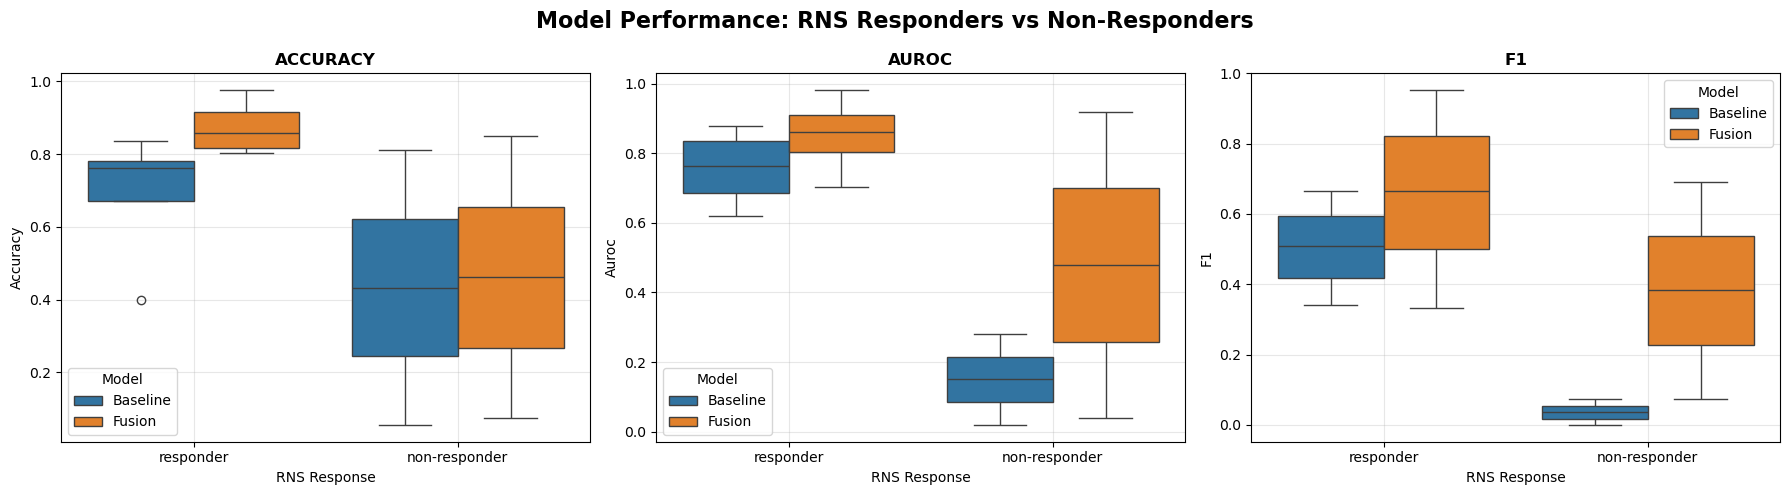


RNS RESPONSE ANALYSIS

RNS Outcome: RESPONDER
Number of patients: 4

ACCURACY:
  Baseline: 0.6903 ± 0.1966
  Fusion:   0.8741 ± 0.0786
  Δ: +0.1838

AUROC:
  Baseline: 0.7567 ± 0.1155
  Fusion:   0.8522 ± 0.1155
  Δ: +0.0954

F1:
  Baseline: 0.5060 ± 0.1425
  Fusion:   0.6548 ± 0.2689
  Δ: +0.1488

RNS Outcome: NON-RESPONDER
Number of patients: 2

ACCURACY:
  Baseline: 0.4334 ± 0.5344
  Fusion:   0.4616 ± 0.5480
  Δ: +0.0281

AUROC:
  Baseline: 0.1503 ± 0.1854
  Fusion:   0.4785 ± 0.6224
  Δ: +0.3282

F1:
  Baseline: 0.0364 ± 0.0514
  Fusion:   0.3832 ± 0.4372
  Δ: +0.3468

COMPARISON: Responders vs Non-Responders

ACCURACY:
  Baseline: Responders=0.6903 vs Non-Responders=0.4334, p=0.4022
  Fusion: Responders=0.8741 vs Non-Responders=0.4616, p=0.1668

AUROC:
  Baseline: Responders=0.7567 vs Non-Responders=0.1503, p=0.0068
  Fusion: Responders=0.8522 vs Non-Responders=0.4785, p=0.2573

F1:
  Baseline: Responders=0.5060 vs Non-Responders=0.0364, p=0.0126
  Fusion: Responders=0.6548 vs N

In [26]:
# Analysis 3: RNS Response (Responder vs Non-Responder)
rns_data = merged_data[merged_data['type'] == 'rns'].copy()

if len(rns_data) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Model Performance: RNS Responders vs Non-Responders', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(['accuracy', 'auroc', 'f1']):
        ax = axes[idx]
        plot_data = rns_data[rns_data[metric].notna()]
        
        sns.boxplot(data=plot_data, x='outcome', y=metric, hue='model', ax=ax)
        ax.set_title(f'{metric.upper()}', fontweight='bold')
        ax.set_xlabel('RNS Response')
        ax.set_ylabel(metric.capitalize())
        ax.legend(title='Model')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("\n" + "="*80)
    print("RNS RESPONSE ANALYSIS")
    print("="*80)
    
    for response in rns_data['outcome'].unique():
        print(f"\n{'='*60}")
        print(f"RNS Outcome: {response.upper()}")
        print(f"{'='*60}")
        
        response_data = rns_data[rns_data['outcome'] == response]
        n_patients = response_data['subj'].nunique()
        print(f"Number of patients: {n_patients}")
        
        for metric in ['accuracy', 'auroc', 'f1']:
            baseline_vals = response_data[response_data['model'] == 'Baseline'][metric].dropna()
            fusion_vals = response_data[response_data['model'] == 'Fusion'][metric].dropna()
            
            if len(baseline_vals) > 0 and len(fusion_vals) > 0:
                print(f"\n{metric.upper()}:")
                print(f"  Baseline: {baseline_vals.mean():.4f} ± {baseline_vals.std():.4f}")
                print(f"  Fusion:   {fusion_vals.mean():.4f} ± {fusion_vals.std():.4f}")
                print(f"  Δ: {(fusion_vals.mean() - baseline_vals.mean()):+.4f}")
    
    # Compare responders vs non-responders
    print(f"\n{'='*60}")
    print("COMPARISON: Responders vs Non-Responders")
    print(f"{'='*60}")
    
    responders = rns_data[rns_data['outcome'] == 'responder']
    non_responders = rns_data[rns_data['outcome'] == 'non-responder']
    
    for metric in ['accuracy', 'auroc', 'f1']:
        print(f"\n{metric.upper()}:")
        
        for model_type in ['Baseline', 'Fusion']:
            resp_vals = responders[responders['model'] == model_type][metric].dropna()
            non_resp_vals = non_responders[non_responders['model'] == model_type][metric].dropna()
            
            if len(resp_vals) > 0 and len(non_resp_vals) > 0:
                t_stat, p_val = stats.ttest_ind(resp_vals, non_resp_vals)
                print(f"  {model_type}: Responders={resp_vals.mean():.4f} vs Non-Responders={non_resp_vals.mean():.4f}, p={p_val:.4f}")
else:
    print("No RNS patients found in dataset")

/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_99875/2189716012.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='outcome', y=metric, ax=ax,
/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_99875/2189716012.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Responder', 'Non-Responder'])
/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_99875/2189716012.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x='outcome', y=metric, ax=ax,
/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_99875/2189716012.py

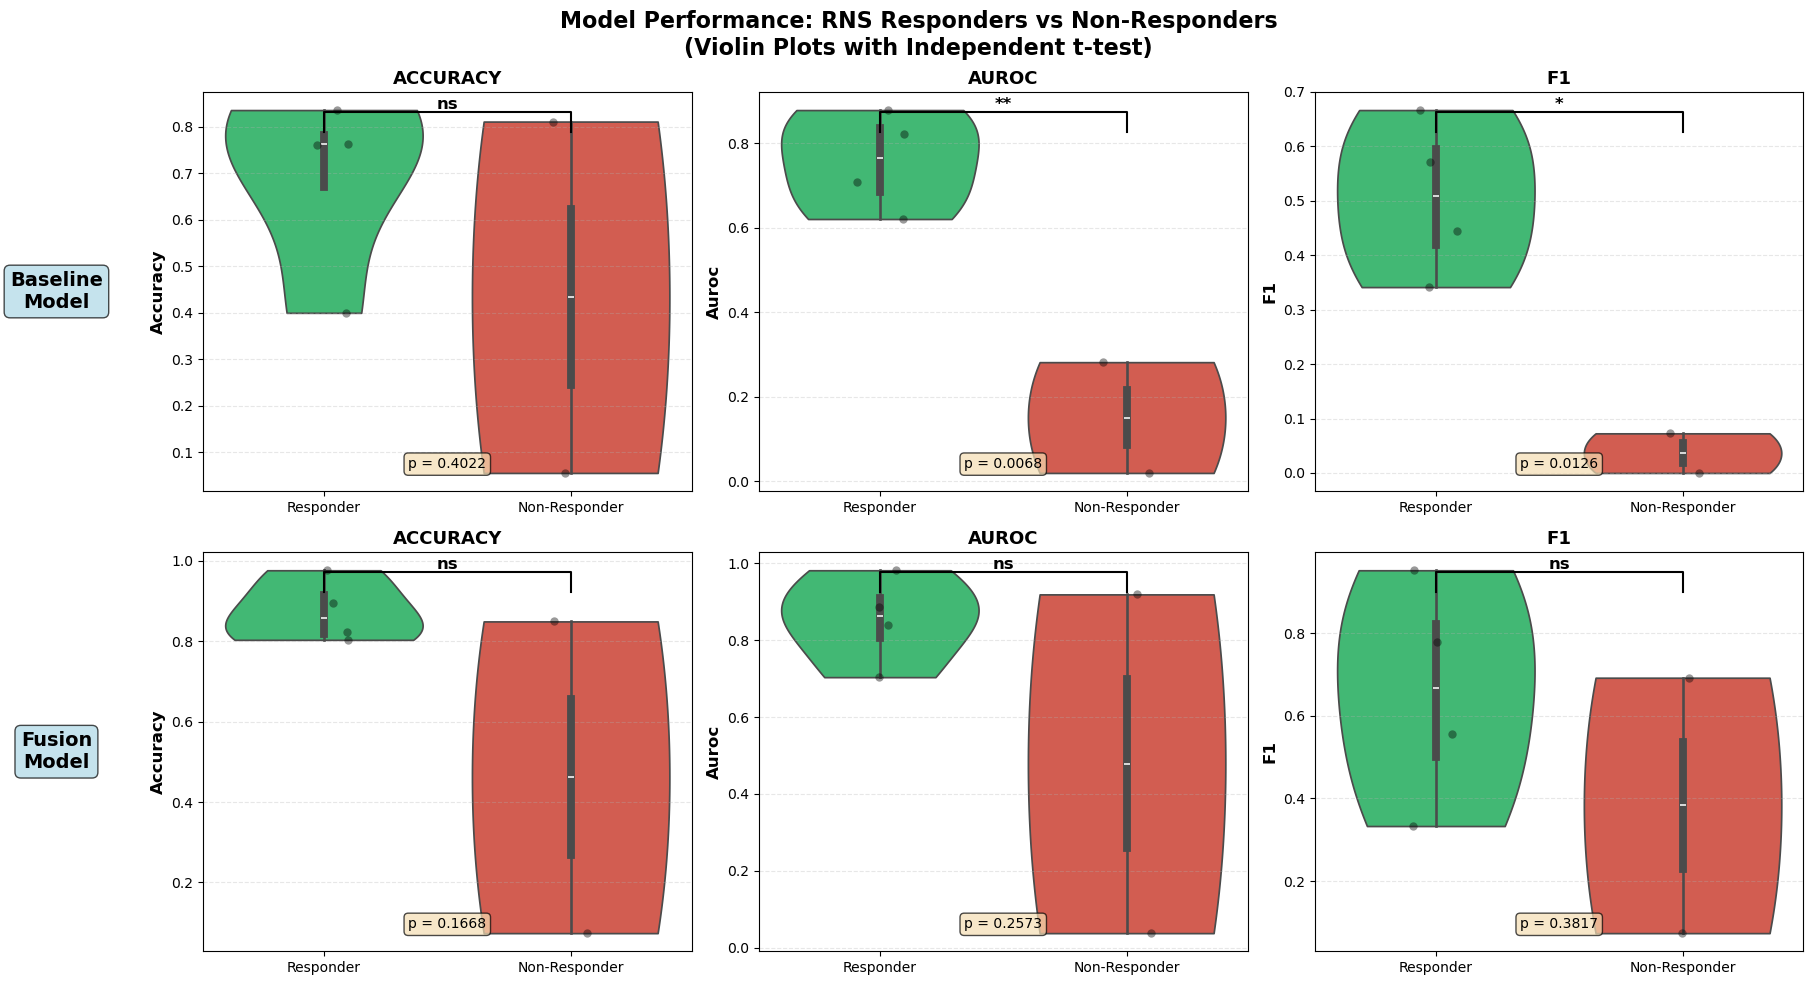


RNS RESPONSE ANALYSIS (REVISED WITH VIOLIN PLOTS)

BASELINE MODEL

RESPONDER: n=4
  accuracy: 0.6903 ± 0.1966
  auroc: 0.7567 ± 0.1155
  f1: 0.5060 ± 0.1425

NON-RESPONDER: n=2
  accuracy: 0.4334 ± 0.5344
  auroc: 0.1503 ± 0.1854
  f1: 0.0364 ± 0.0514

  RESPONDER vs NON-RESPONDER COMPARISON:
    accuracy: Δ=+0.2568, t=0.9361, p=0.4022
    auroc: Δ=+0.6064, t=5.1355, p=0.0068
    f1: Δ=+0.4696, t=4.3006, p=0.0126

FUSION MODEL

RESPONDER: n=4
  accuracy: 0.8741 ± 0.0786
  auroc: 0.8522 ± 0.1155
  f1: 0.6548 ± 0.2689

NON-RESPONDER: n=2
  accuracy: 0.4616 ± 0.5480
  auroc: 0.4785 ± 0.6224
  f1: 0.3832 ± 0.4372

  RESPONDER vs NON-RESPONDER COMPARISON:
    accuracy: Δ=+0.4125, t=1.6872, p=0.1668
    auroc: Δ=+0.3736, t=1.3199, p=0.2573
    f1: Δ=+0.2716, t=0.9819, p=0.3817

SIGNIFICANCE LEVELS: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05


In [8]:
# Analysis 3 REVISED: RNS Response with Violin Plots
rns_data_revised = merged_data[merged_data['type'] == 'rns'].copy()

def add_stat_annotation_violin(ax, x1, x2, y, p_value, h=0.02):
    """Add statistical significance annotation to plot"""
    if p_value < 0.001:
        sig_symbol = '***'
    elif p_value < 0.01:
        sig_symbol = '**'
    elif p_value < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'
    
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*0.5, y+h, sig_symbol, ha='center', va='bottom', fontsize=12, fontweight='bold')

if len(rns_data_revised) > 0:
    # Create separate plots for Baseline and Fusion models
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Performance: RNS Responders vs Non-Responders\n(Violin Plots with Independent t-test)',
                 fontsize=16, fontweight='bold')
    
    key_metrics = ['accuracy', 'auroc', 'f1']
    
    for model_idx, model_type in enumerate(['Baseline', 'Fusion']):
        model_data = rns_data_revised[rns_data_revised['model'] == model_type]
        
        for metric_idx, metric in enumerate(key_metrics):
            ax = axes[model_idx, metric_idx]
            
            # Create violin plot using seaborn
            plot_data = model_data[model_data[metric].notna()]
            
            sns.violinplot(data=plot_data, x='outcome', y=metric, ax=ax,
                          palette={'responder': '#2ecc71', 'non-responder': '#e74c3c'},
                          inner='box', cut=0)
            
            # Add individual points
            sns.stripplot(data=plot_data, x='outcome', y=metric, ax=ax,
                         color='black', alpha=0.4, size=6, jitter=True)
            
            # Get data for statistics
            responders = model_data[model_data['outcome'] == 'responder'][metric].dropna()
            non_responders = model_data[model_data['outcome'] == 'non-responder'][metric].dropna()
            
            # Statistical test
            if len(responders) > 0 and len(non_responders) > 0:
                t_stat, p_val = stats.ttest_ind(responders, non_responders)
                
                # Add significance annotation
                y_max = ax.get_ylim()[1]
                y_min = ax.get_ylim()[0]
                y_range = y_max - y_min
                y_annotation = y_max - 0.1 * y_range
                
                add_stat_annotation_violin(ax, 0, 1, y_annotation, p_val, h=0.05*y_range)
                
                # Add p-value text
                ax.text(0.5, 0.05, f'p = {p_val:.4f}', transform=ax.transAxes,
                       ha='center', va='bottom', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
            
            # Formatting
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric.capitalize()}', fontsize=12, fontweight='bold')
            ax.set_title(f'{metric.upper()}', fontsize=13, fontweight='bold')
            ax.set_xticklabels(['Responder', 'Non-Responder'])
            ax.grid(True, alpha=0.3, axis='y', linestyle='--')
            
            # Add model label on the left
            if metric_idx == 0:
                ax.text(-0.3, 0.5, f'{model_type}\nModel', transform=ax.transAxes,
                       fontsize=14, fontweight='bold', va='center', ha='center',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("\n" + "="*80)
    print("RNS RESPONSE ANALYSIS (REVISED WITH VIOLIN PLOTS)")
    print("="*80)
    
    for model_type in ['Baseline', 'Fusion']:
        print(f"\n{'='*60}")
        print(f"{model_type.upper()} MODEL")
        print(f"{'='*60}")
        
        model_data = rns_data_revised[rns_data_revised['model'] == model_type]
        
        for response in ['responder', 'non-responder']:
            response_data = model_data[model_data['outcome'] == response]
            n_patients = response_data['subj'].nunique()
            print(f"\n{response.upper()}: n={n_patients}")
            
            for metric in ['accuracy', 'auroc', 'f1']:
                vals = response_data[metric].dropna()
                if len(vals) > 0:
                    print(f"  {metric}: {vals.mean():.4f} ± {vals.std():.4f}")
        
        # Statistical comparison
        print(f"\n  RESPONDER vs NON-RESPONDER COMPARISON:")
        responders = model_data[model_data['outcome'] == 'responder']
        non_responders = model_data[model_data['outcome'] == 'non-responder']
        
        for metric in ['accuracy', 'auroc', 'f1']:
            resp_vals = responders[metric].dropna()
            non_resp_vals = non_responders[metric].dropna()
            
            if len(resp_vals) > 0 and len(non_resp_vals) > 0:
                t_stat, p_val = stats.ttest_ind(resp_vals, non_resp_vals)
                print(f"    {metric}: Δ={resp_vals.mean() - non_resp_vals.mean():+.4f}, t={t_stat:.4f}, p={p_val:.4f}")
    
    print("\n" + "="*80)
    print("SIGNIFICANCE LEVELS: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05")
    print("="*80)
else:
    print("No RNS patients found in dataset")

In [30]:
# Load noise analysis data
noise_data = pd.read_csv('pathway_importance_20251205_164827.csv')

print("Noise analysis data loaded:")
print(f"Shape: {noise_data.shape}")
print(f"\nColumns: {noise_data.columns.tolist()}")
print(f"\nUnique subjects: {noise_data['subject'].nunique()}")
print(f"Unique conditions: {noise_data['condition'].unique()}")
print(f"Noise levels (std): {sorted(noise_data['noise_std'].unique())}")
print(f"\nFirst few rows:")
print(noise_data.head(10))

Noise analysis data loaded:
Shape: (360, 11)

Columns: ['subject', 'condition', 'noise_std', 'accuracy', 'auroc', 'f1', 'sensitivity', 'specificity', 'youden_index', 'precision', 'recall']

Unique subjects: 20
Unique conditions: ['convergent_noisy' 'divergent_noisy' 'both_noisy']
Noise levels (std): [np.float64(0.0), np.float64(2.0), np.float64(4.0), np.float64(6.0), np.float64(8.0), np.float64(10.0)]

First few rows:
  subject         condition  noise_std  accuracy     auroc        f1  \
0  Epat26  convergent_noisy        0.0  0.698113  0.902326  0.555556   
1  Epat26   divergent_noisy        0.0  0.698113  0.902326  0.555556   
2  Epat26        both_noisy        0.0  0.698113  0.902326  0.555556   
3  Epat26  convergent_noisy        2.0  0.584906  0.806977  0.450000   
4  Epat26   divergent_noisy        2.0  0.679245  0.888372  0.540541   
5  Epat26        both_noisy        2.0  0.679245  0.827907  0.514286   
6  Epat26  convergent_noisy        4.0  0.528302  0.758140  0.444444   
7 

In [31]:
# Calculate baseline performance (noise_std = 0.0) for each subject and condition
baseline_performance = noise_data[noise_data['noise_std'] == 0.0].copy()
baseline_performance = baseline_performance.rename(columns={
    'accuracy': 'baseline_accuracy',
    'auroc': 'baseline_auroc',
    'f1': 'baseline_f1',
    'sensitivity': 'baseline_sensitivity',
    'specificity': 'baseline_specificity',
    'youden_index': 'baseline_youden_index',
    'precision': 'baseline_precision',
    'recall': 'baseline_recall'
})

# Keep only baseline metrics and identifiers
baseline_cols = ['subject', 'condition'] + [col for col in baseline_performance.columns if 'baseline_' in col]
baseline_performance = baseline_performance[baseline_cols]

# Merge baseline back with full dataset
noise_with_baseline = noise_data.merge(baseline_performance, on=['subject', 'condition'], how='left')

# Calculate deviations from baseline for each metric
metrics = ['accuracy', 'auroc', 'f1', 'sensitivity', 'specificity', 'youden_index', 'precision', 'recall']

for metric in metrics:
    noise_with_baseline[f'{metric}_deviation'] = noise_with_baseline[metric] - noise_with_baseline[f'baseline_{metric}']

print("Deviation metrics calculated!")
print(f"\nDeviation columns: {[col for col in noise_with_baseline.columns if 'deviation' in col]}")
print(f"\nExample deviations for first subject:")
example = noise_with_baseline[noise_with_baseline['subject'] == noise_with_baseline['subject'].iloc[0]]
print(example[['subject', 'condition', 'noise_std', 'accuracy', 'baseline_accuracy', 'accuracy_deviation']].head(15))

Deviation metrics calculated!

Deviation columns: ['accuracy_deviation', 'auroc_deviation', 'f1_deviation', 'sensitivity_deviation', 'specificity_deviation', 'youden_index_deviation', 'precision_deviation', 'recall_deviation']

Example deviations for first subject:
   subject         condition  noise_std  accuracy  baseline_accuracy  \
0   Epat26  convergent_noisy        0.0  0.698113           0.698113   
1   Epat26   divergent_noisy        0.0  0.698113           0.698113   
2   Epat26        both_noisy        0.0  0.698113           0.698113   
3   Epat26  convergent_noisy        2.0  0.584906           0.698113   
4   Epat26   divergent_noisy        2.0  0.679245           0.698113   
5   Epat26        both_noisy        2.0  0.679245           0.698113   
6   Epat26  convergent_noisy        4.0  0.528302           0.698113   
7   Epat26   divergent_noisy        4.0  0.528302           0.698113   
8   Epat26        both_noisy        4.0  0.566038           0.698113   
9   Epat26  co

In [ ]:
# Calculate mean and confidence intervals for each noise level and condition
from scipy.stats import sem, t

def calculate_ci(data, confidence=0.95):
    """Calculate confidence interval for the mean"""
    n = len(data)
    if n < 2:
        return 0
    mean = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return h

# Group by condition and noise level
summary_stats = []

for condition in noise_with_baseline['condition'].unique():
    for noise_level in sorted(noise_with_baseline['noise_std'].unique()):
        subset = noise_with_baseline[(noise_with_baseline['condition'] == condition) & 
                                     (noise_with_baseline['noise_std'] == noise_level)]
        
        stats_row = {
            'condition': condition,
            'noise_std': noise_level
        }
        
        for metric in metrics:
            deviation_col = f'{metric}_deviation'
            values = subset[deviation_col].dropna()
            
            if len(values) > 0:
                stats_row[f'{metric}_mean_deviation'] = values.mean()
                stats_row[f'{metric}_ci'] = calculate_ci(values)
                stats_row[f'{metric}_std'] = values.std()
                stats_row[f'{metric}_n'] = len(values)
        
        summary_stats.append(stats_row)

summary_df = pd.DataFrame(summary_stats)

print(f"\nShape: {summary_df.shape}")
print(f"\nExample for convergent_noisy condition:")
print(summary_df[summary_df['condition'] == 'convergent_noisy'][
    ['condition', 'noise_std', 'accuracy_mean_deviation', 'accuracy_ci', 'accuracy_n']
])

Summary statistics calculated!

Shape: (18, 34)

Example for convergent_noisy condition:
          condition  noise_std  accuracy_mean_deviation  accuracy_ci  \
0  convergent_noisy        0.0                 0.000000     0.000000   
1  convergent_noisy        2.0                 0.002121     0.036274   
2  convergent_noisy        4.0                 0.037245     0.078424   
3  convergent_noisy        6.0                 0.040309     0.105196   
4  convergent_noisy        8.0                 0.049057     0.133385   
5  convergent_noisy       10.0                 0.021656     0.138359   

   accuracy_n  
0          20  
1          20  
2          20  
3          20  
4          20  
5          20  


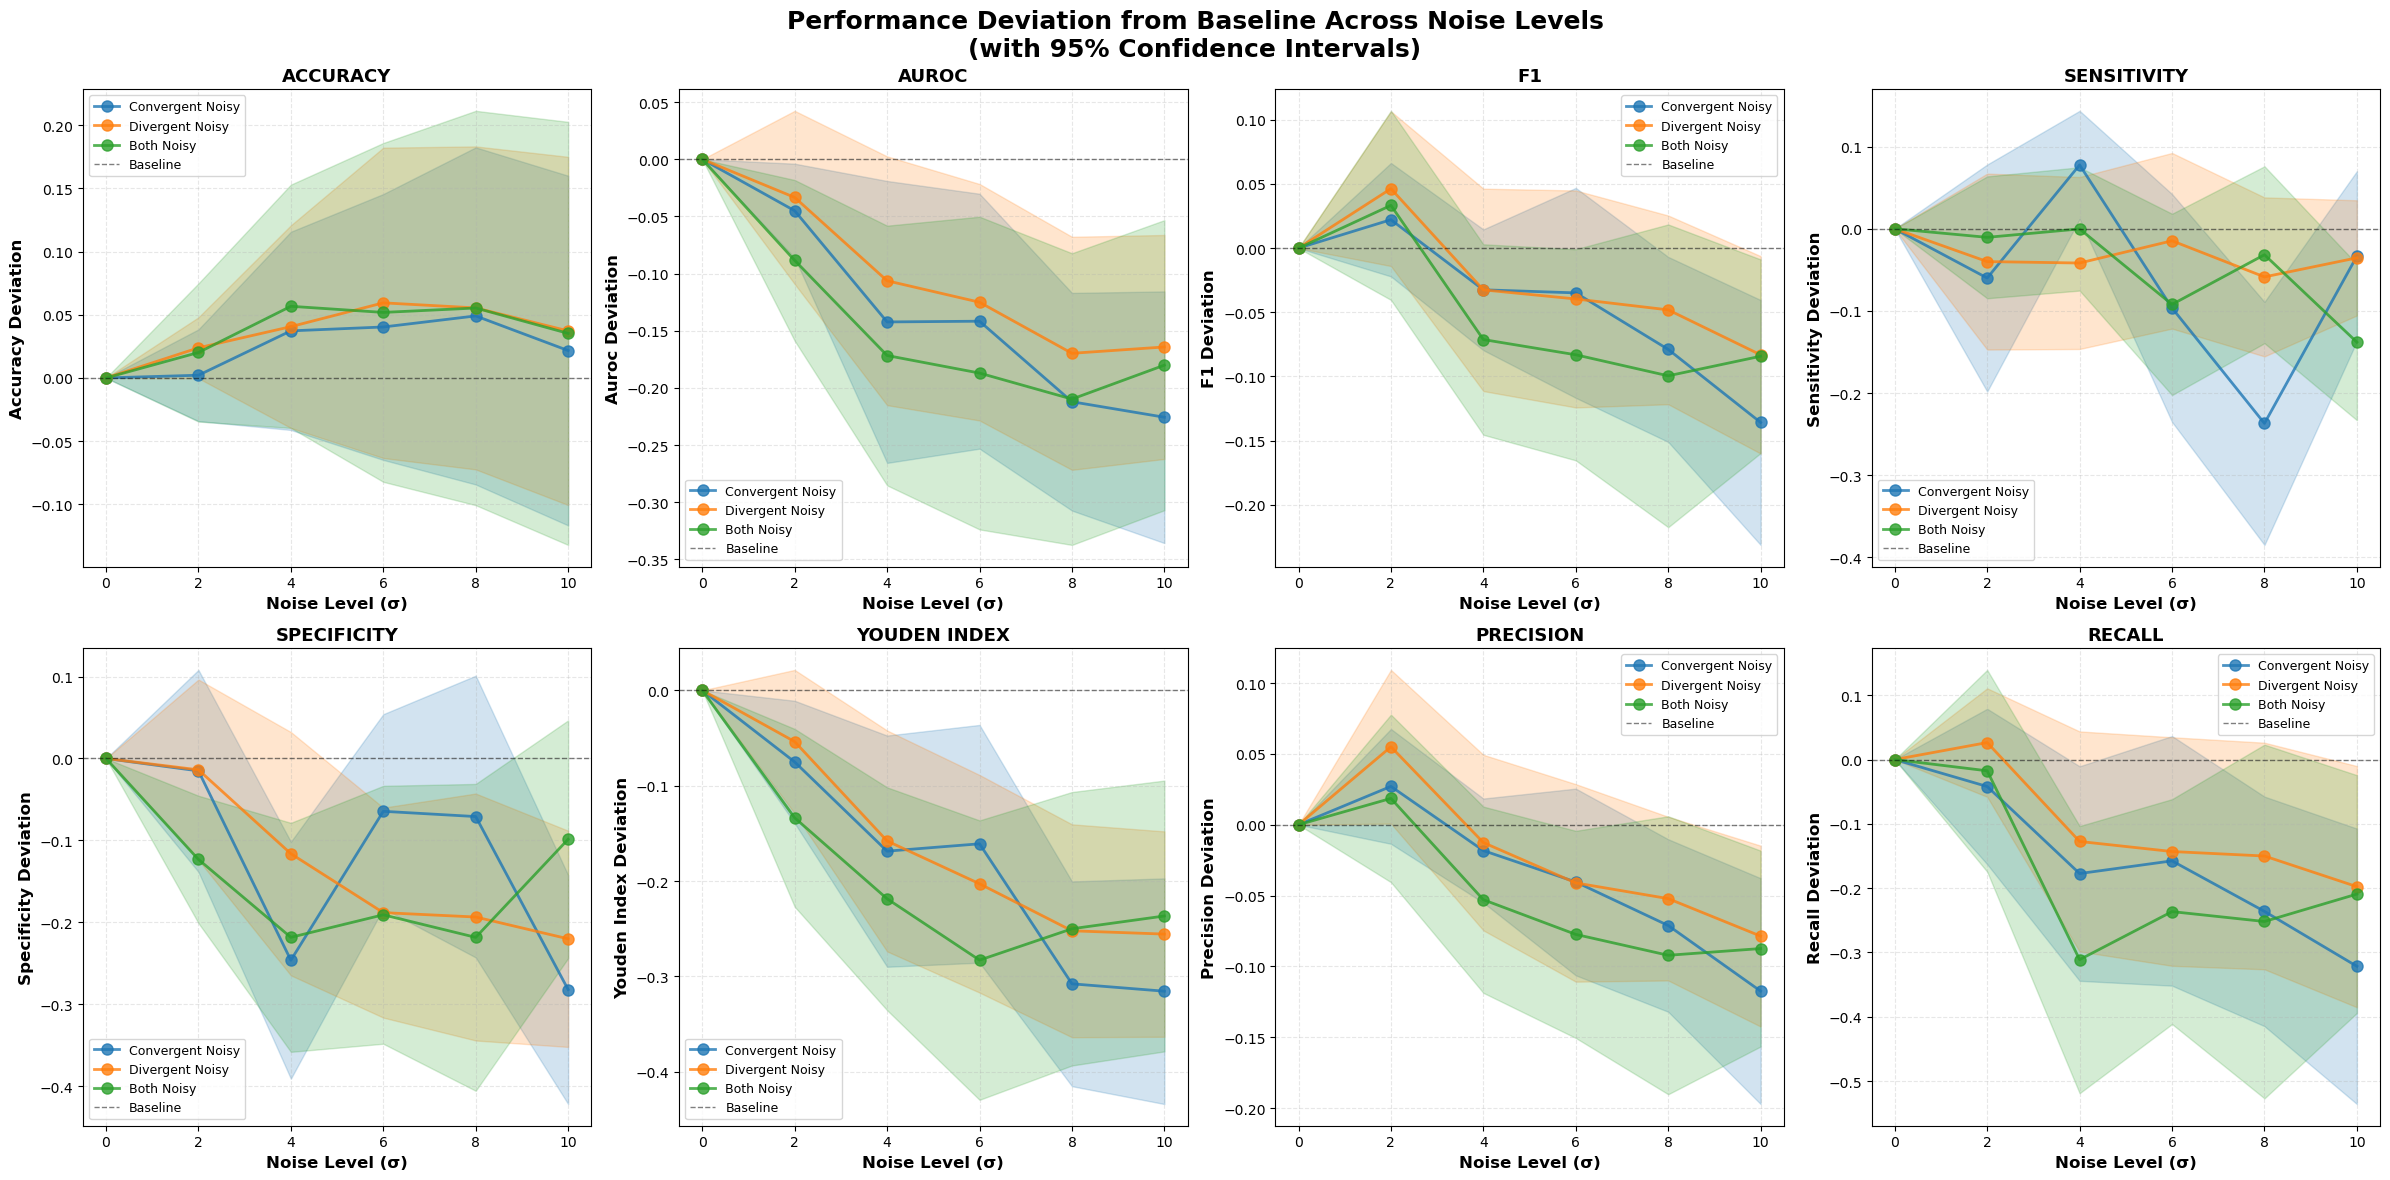

In [33]:
# Create line plots showing deviation from baseline with confidence intervals
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
fig.suptitle('Performance Deviation from Baseline Across Noise Levels\n(with 95% Confidence Intervals)', 
             fontsize=18, fontweight='bold')

# Color scheme for conditions
colors = {
    'convergent_noisy': '#1f77b4',  # blue
    'divergent_noisy': '#ff7f0e',   # orange
    'both_noisy': '#2ca02c'         # green
}

# Plot each metric
for idx, metric in enumerate(metrics):
    ax = axes[idx // 4, idx % 4]
    
    for condition in ['convergent_noisy', 'divergent_noisy', 'both_noisy']:
        condition_data = summary_df[summary_df['condition'] == condition].sort_values('noise_std')
        
        x = condition_data['noise_std']
        y = condition_data[f'{metric}_mean_deviation']
        ci = condition_data[f'{metric}_ci']
        
        # Plot line with markers
        ax.plot(x, y, marker='o', linewidth=2, markersize=8, 
               label=condition.replace('_', ' ').title(), 
               color=colors[condition], alpha=0.8)
        
        # Add confidence interval shading
        ax.fill_between(x, y - ci, y + ci, alpha=0.2, color=colors[condition])
    
    # Add horizontal line at y=0 (baseline)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Baseline')
    
    # Formatting
    ax.set_xlabel('Noise Level (σ)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{metric.replace("_", " ").title()} Deviation', fontsize=12, fontweight='bold')
    ax.set_title(metric.replace('_', ' ').upper(), fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=9)
    
    # Set x-axis to show all noise levels
    ax.set_xticks(sorted(summary_df['noise_std'].unique()))

plt.tight_layout()
plt.show()

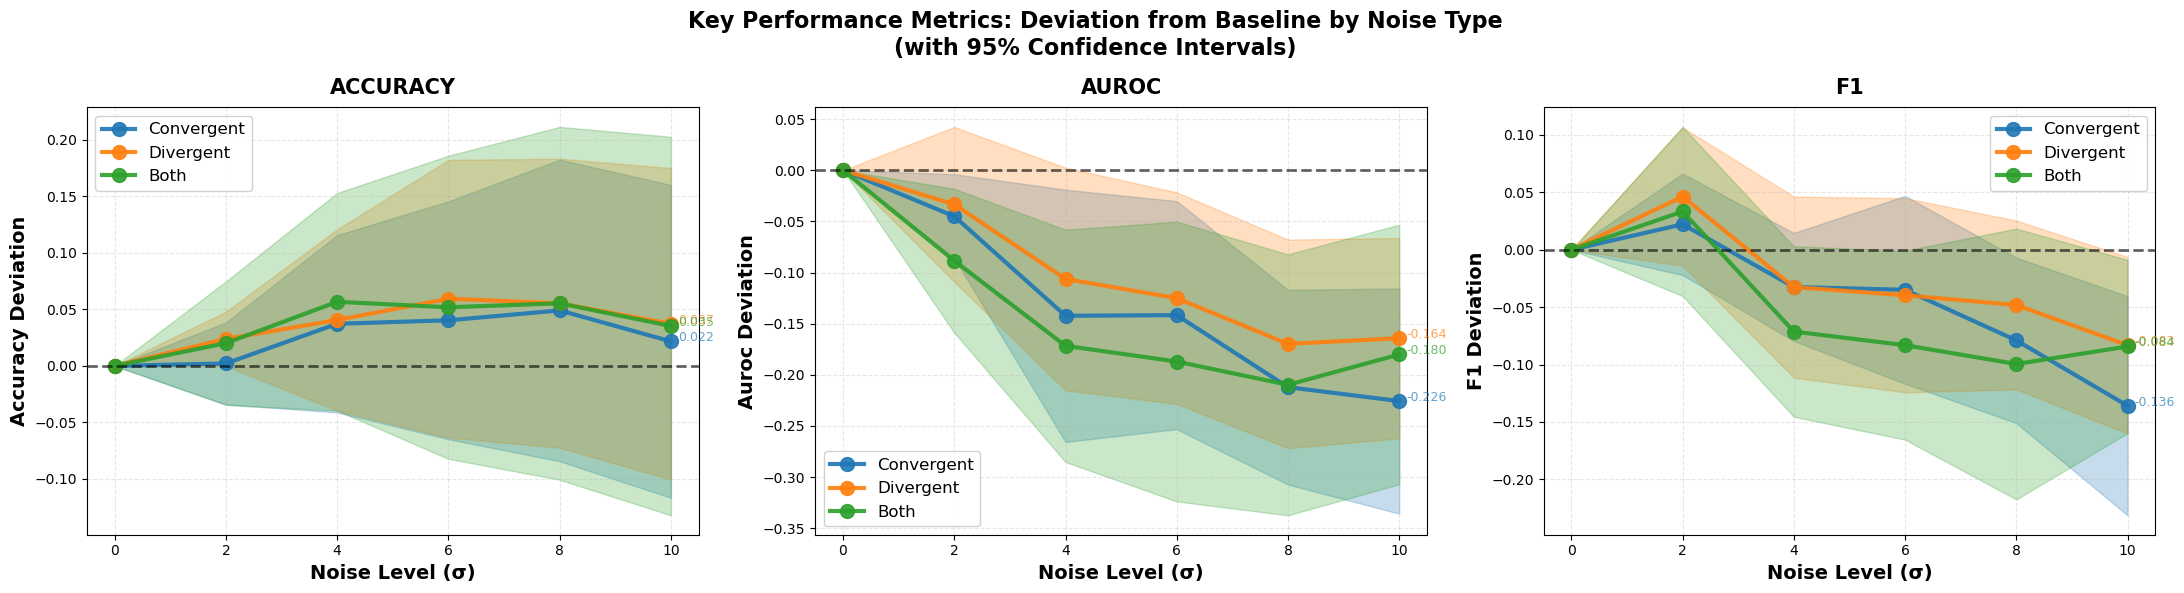

In [35]:
# Create focused plot on key metrics (Accuracy, AUROC, F1)
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle('Key Performance Metrics: Deviation from Baseline by Noise Type\n(with 95% Confidence Intervals)', 
             fontsize=16, fontweight='bold')

key_metrics = ['accuracy', 'auroc', 'f1']

for idx, metric in enumerate(key_metrics):
    ax = axes[idx]
    
    for condition in ['convergent_noisy', 'divergent_noisy', 'both_noisy']:
        condition_data = summary_df[summary_df['condition'] == condition].sort_values('noise_std')
        
        x = condition_data['noise_std']
        y = condition_data[f'{metric}_mean_deviation']
        ci = condition_data[f'{metric}_ci']
        
        # Plot line with markers
        ax.plot(x, y, marker='o', linewidth=3, markersize=10, 
               label=condition.replace('_noisy', '').title(), 
               color=colors[condition], alpha=0.9)
        
        # Add confidence interval shading
        ax.fill_between(x, y - ci, y + ci, alpha=0.25, color=colors[condition])
    
    # Add horizontal line at y=0 (baseline)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.6)
    
    # Formatting
    ax.set_xlabel('Noise Level (σ)', fontsize=14, fontweight='bold')
    ax.set_ylabel(f'{metric.replace("_", " ").title()} Deviation', fontsize=14, fontweight='bold')
    ax.set_title(metric.upper(), fontsize=15, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=12, framealpha=0.9)
    
    # Set x-axis to show all noise levels
    ax.set_xticks(sorted(summary_df['noise_std'].unique()))
    
    # Add annotations for the final noise level
    final_noise = sorted(summary_df['noise_std'].unique())[-1]
    for condition in ['convergent_noisy', 'divergent_noisy', 'both_noisy']:
        final_val = summary_df[(summary_df['condition'] == condition) & 
                               (summary_df['noise_std'] == final_noise)][f'{metric}_mean_deviation'].values
        if len(final_val) > 0:
            ax.annotate(f'{final_val[0]:.3f}', 
                       xy=(final_noise, final_val[0]), 
                       xytext=(5, 0), textcoords='offset points',
                       fontsize=9, alpha=0.7, color=colors[condition])

plt.tight_layout()
plt.show()

/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_58570/208230858.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels, patch_artist=True,
/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_58570/208230858.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels, patch_artist=True,
/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel_58570/208230858.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels, patch_artist=True,
/var/folders/qr/ddtvwtlx5xvc5jyb2sw669y00000gn/T/ipykernel

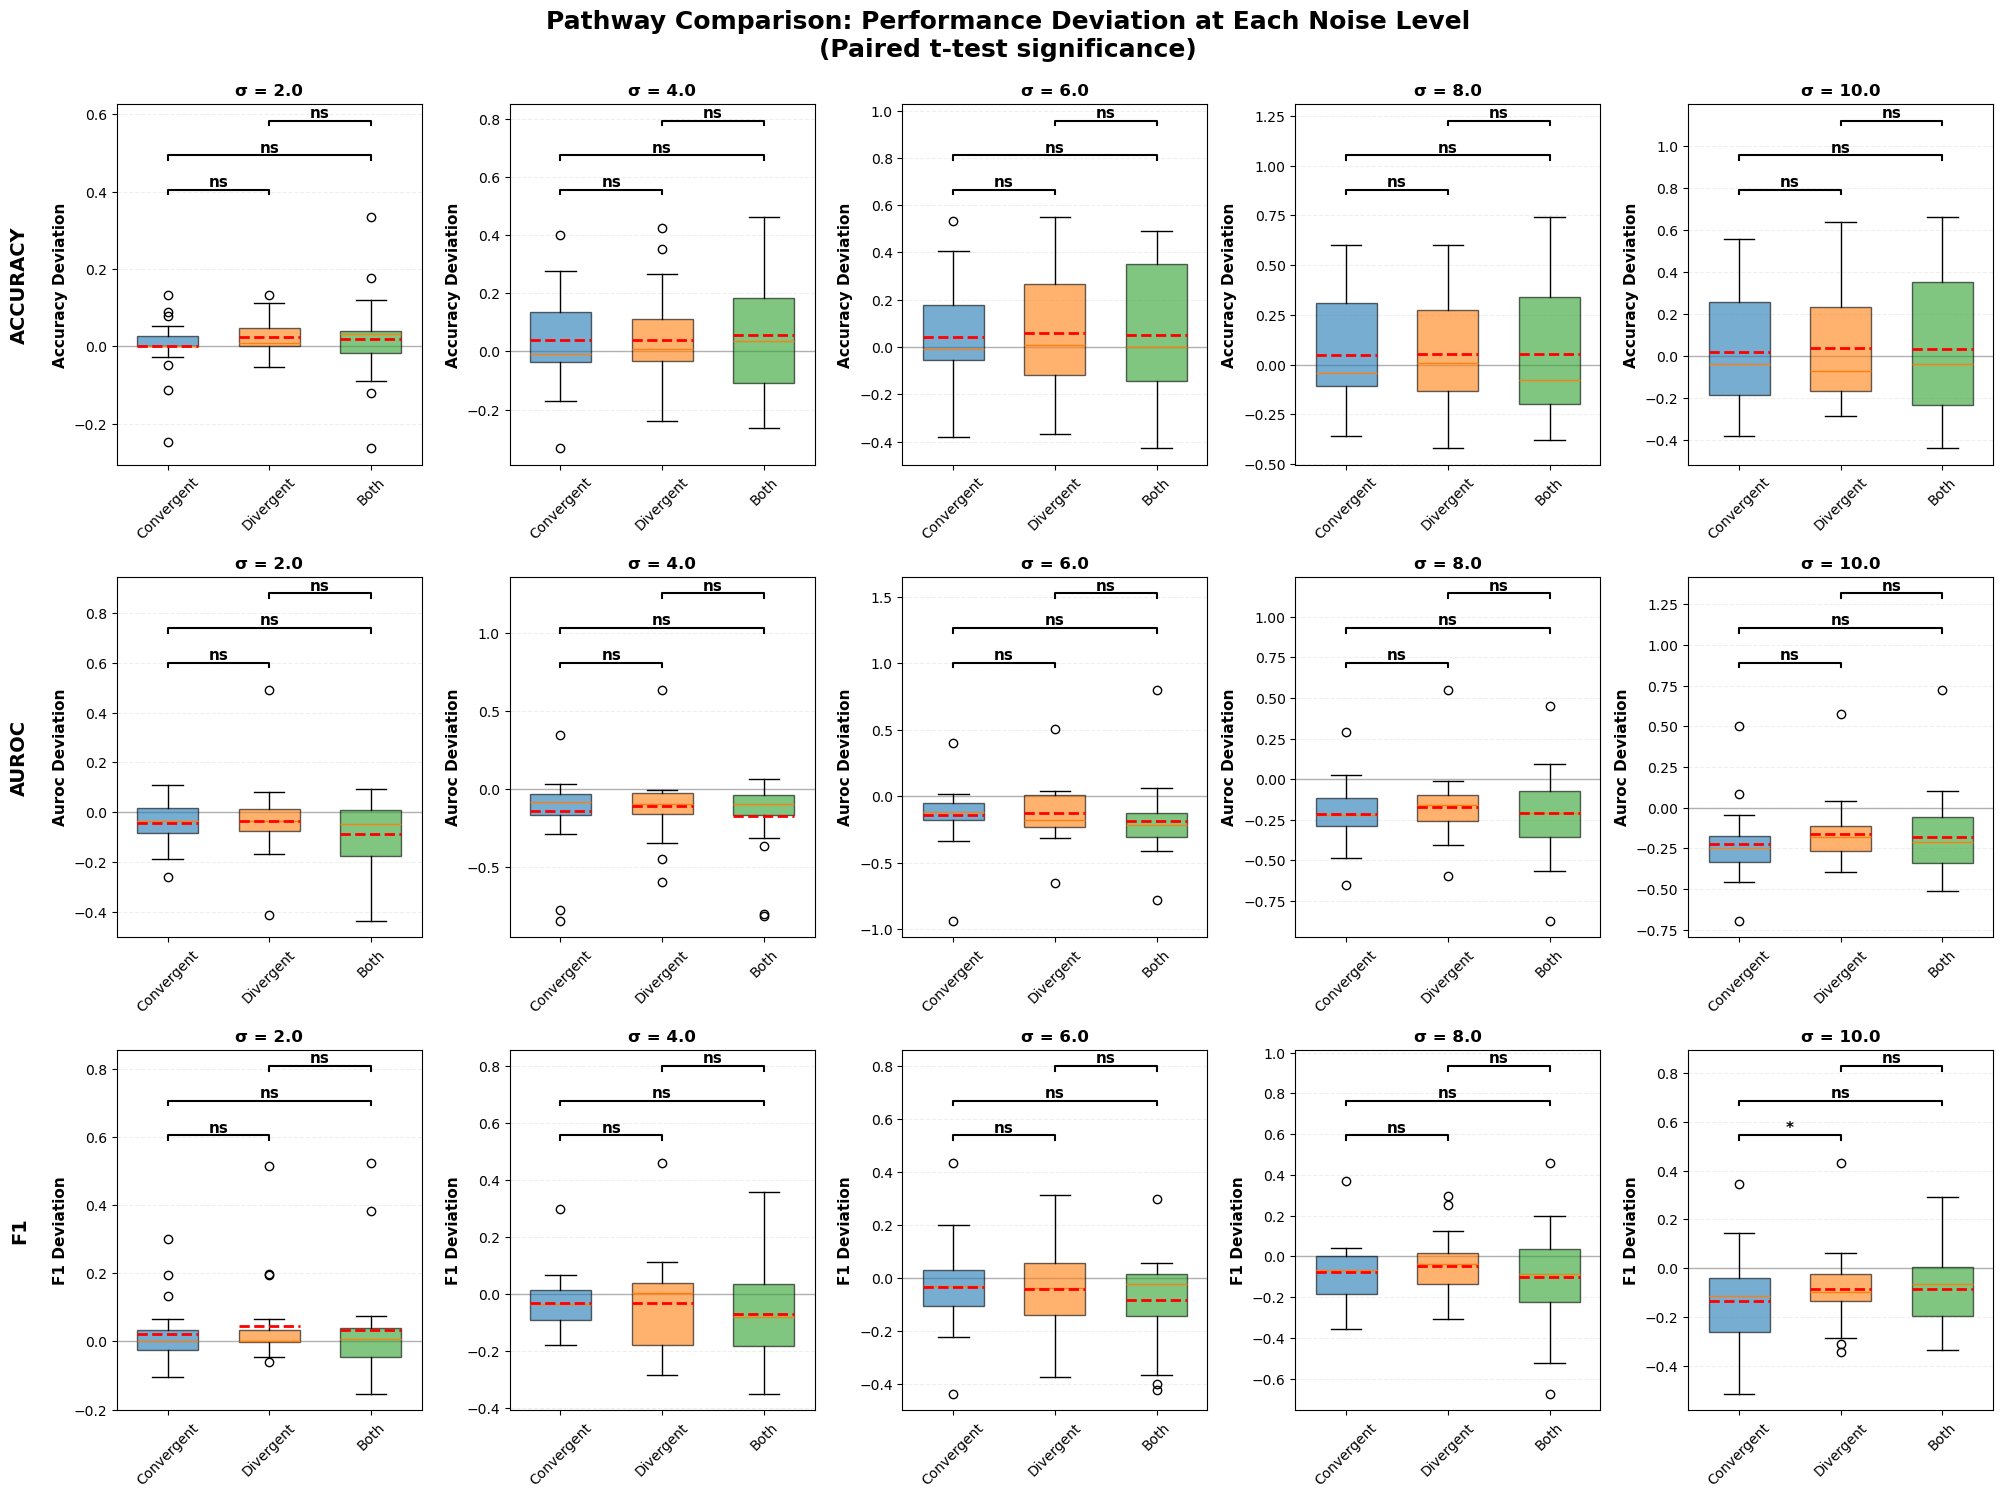


SIGNIFICANCE LEVELS:
***  p < 0.001 (highly significant)
**   p < 0.01  (very significant)
*    p < 0.05  (significant)
ns   p ≥ 0.05  (not significant)

Note: All tests are paired t-tests (same patients across conditions)


In [36]:
# Box plots comparing convergent vs divergent pathways at each noise level with significance
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.patches as mpatches

def add_stat_annotation(ax, x1, x2, y, p_value, h=0.02):
    """Add statistical significance annotation to plot"""
    # Determine significance level
    if p_value < 0.001:
        sig_symbol = '***'
    elif p_value < 0.01:
        sig_symbol = '**'
    elif p_value < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'
    
    # Draw bar
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    # Add text
    ax.text((x1+x2)*0.5, y+h, sig_symbol, ha='center', va='bottom', fontsize=11, fontweight='bold')

# Filter out baseline (noise_std = 0)
noise_only_data = noise_with_baseline[noise_with_baseline['noise_std'] > 0].copy()

# Get unique noise levels (excluding baseline)
noise_levels = sorted(noise_only_data['noise_std'].unique())

# Create box plots for key metrics
key_metrics = ['accuracy', 'auroc', 'f1']
fig, axes = plt.subplots(len(key_metrics), len(noise_levels), 
                         figsize=(4*len(noise_levels), 5*len(key_metrics)))

fig.suptitle('Pathway Comparison: Performance Deviation at Each Noise Level\n(Paired t-test significance)', 
             fontsize=18, fontweight='bold', y=0.995)

for metric_idx, metric in enumerate(key_metrics):
    for noise_idx, noise_level in enumerate(noise_levels):
        ax = axes[metric_idx, noise_idx]
        
        # Get data for this noise level
        noise_subset = noise_only_data[noise_only_data['noise_std'] == noise_level]
        
        # Prepare data for box plot
        plot_data = []
        labels = []
        
        for condition in ['convergent_noisy', 'divergent_noisy', 'both_noisy']:
            condition_data = noise_subset[noise_subset['condition'] == condition][f'{metric}_deviation'].dropna()
            plot_data.append(condition_data)
            labels.append(condition.replace('_noisy', '').title())
        
        # Create box plot
        bp = ax.boxplot(plot_data, labels=labels, patch_artist=True,
                       widths=0.6, showmeans=True, meanline=True,
                       meanprops=dict(color='red', linewidth=2, linestyle='--'))
        
        # Color boxes
        box_colors = [colors['convergent_noisy'], colors['divergent_noisy'], colors['both_noisy']]
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        # Add horizontal line at y=0 (baseline)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3, zorder=0)
        
        # Statistical testing: paired t-test between convergent and divergent
        conv_data = noise_subset[noise_subset['condition'] == 'convergent_noisy'][['subject', f'{metric}_deviation']]
        div_data = noise_subset[noise_subset['condition'] == 'divergent_noisy'][['subject', f'{metric}_deviation']]
        paired_data = conv_data.merge(div_data, on='subject', suffixes=('_conv', '_div'))
        
        if len(paired_data) > 1:
            t_stat, p_val_conv_div = ttest_rel(paired_data[f'{metric}_deviation_conv'], 
                                               paired_data[f'{metric}_deviation_div'])
            
            # Add significance annotation between convergent and divergent
            y_max = max([max(d) for d in plot_data if len(d) > 0])
            y_min = min([min(d) for d in plot_data if len(d) > 0])
            y_range = y_max - y_min
            y_annotation = y_max + 0.1 * y_range
            
            add_stat_annotation(ax, 1, 2, y_annotation, p_val_conv_div, h=0.02*y_range)
        
        # Test convergent vs both
        both_data = noise_subset[noise_subset['condition'] == 'both_noisy'][['subject', f'{metric}_deviation']]
        paired_conv_both = conv_data.merge(both_data, on='subject', suffixes=('_conv', '_both'))
        
        if len(paired_conv_both) > 1:
            t_stat, p_val_conv_both = ttest_rel(paired_conv_both[f'{metric}_deviation_conv'], 
                                                paired_conv_both[f'{metric}_deviation_both'])
            
            y_annotation2 = y_annotation + 0.15 * y_range
            add_stat_annotation(ax, 1, 3, y_annotation2, p_val_conv_both, h=0.02*y_range)
        
        # Test divergent vs both
        paired_div_both = div_data.merge(both_data, on='subject', suffixes=('_div', '_both'))
        
        if len(paired_div_both) > 1:
            t_stat, p_val_div_both = ttest_rel(paired_div_both[f'{metric}_deviation_div'], 
                                               paired_div_both[f'{metric}_deviation_both'])
            
            y_annotation3 = y_annotation2 + 0.15 * y_range
            add_stat_annotation(ax, 2, 3, y_annotation3, p_val_div_both, h=0.02*y_range)
        
        # Formatting
        ax.set_ylabel(f'{metric.title()} Deviation', fontsize=11, fontweight='bold')
        ax.set_title(f'σ = {noise_level}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.2, axis='y', linestyle='--')
        ax.tick_params(axis='x', rotation=45)
        
        # Add row labels
        if noise_idx == 0:
            ax.text(-0.35, 0.5, metric.upper(), transform=ax.transAxes,
                   fontsize=14, fontweight='bold', va='center', rotation=90)

plt.tight_layout()
plt.show()

# Legend for significance levels
print("\n" + "="*80)
print("SIGNIFICANCE LEVELS:")
print("="*80)
print("***  p < 0.001 (highly significant)")
print("**   p < 0.01  (very significant)")
print("*    p < 0.05  (significant)")
print("ns   p ≥ 0.05  (not significant)")
print("\nNote: All tests are paired t-tests (same patients across conditions)")